##  Classifying audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo<br/>
<br/>

This notebook is part of the project "Urban sounds classification with Covnolutional Neural Networks" on [my Github](https://github.com/GorillaBus/urban-audio-classifier).<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

# Training CNN model with augmented data

We are now able to train our basic -but yet well performing- CNN architecture with the new augmented data. While the initial dataset had 8,732 samples, the augmented dataset has 69,856, that is 8x more information than previous experiments.<br/>
We'll use Log-Mel Spectrograms as features because they showed to perform better than MFCC in our experiments.<br/>
<br/>
As an important note, we are going to train from augmented data but we are only going to test with samples from the original dataset: we want to know how the augmented data helps to improve predictions of the original data.<br/>
<br/>

#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

Using TensorFlow backend.


In [2]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
orig_metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
aug_metadata_path = os.path.abspath('data/augmented-data.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')
audio_path = os.path.join(us8k_path, 'audio')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [5]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

#### * Load data

In [3]:
# Pre-processed MEL SPEC coefficients
X = np.load("data/X-mel_spec-augmented.npy")
y = np.load("data/y-mel_spec-augmented.npy")

# Metadata
metadata = pd.read_csv(orig_metadata_path)
aug_metadata = pd.read_csv(aug_metadata_path)

### 1. Data preparation: features + metadata

#### 1.1 Train / Test split

We are doing split data with the mentioned criteria in an extremely simple fashion: splitting 20% of the augmented dataset into test and then removing all reference to augmented samples from it. We'll end up with an amount of test data that will always be around 1700+ samples.<br/>
<br/>

In [13]:
indexes = []
total = len(aug_metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split metadata
test_meta = aug_metadata.iloc[test_split_idx]
train_meta = aug_metadata.iloc[train_split_idx]

# Remove augmented data from test metadata split
test_meta = test_meta[test_meta['augment'] != 'none']
aug_on_test_idx = test_meta.index.tolist()

# Split the features with the same indexes
X_test = np.take(X, aug_on_test_idx, axis=0)
y_test = np.take(y, aug_on_test_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)


# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta)-len(aug_on_test_idx), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1770 		 Train split: 55885
X test shape: (12201, 40, 174) 	 X train shape: (55885, 40, 174)
y test shape: (12201,) 		 y train shape: (55885,)


#### 1.2 One hot encode labels

In [14]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [15]:
# How data should be organized
num_rows = 40
num_columns = 174
num_channels = 1

# Reshape to fit the network input (channel last!)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

### 2. Basic CNN model

We are using the exact same model than the previous notebooks

#### 2.1 Model definition

In [32]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())

    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.001

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### 2.2 Setup model optimizer and loss function

In [33]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 36, 170, 32)      

#### 2.3 Compile model

In [34]:
num_epochs = 53
num_batch_size = 128
model_file = 'aug-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 51227 samples, validate on 4658 samples
Epoch 1/48
51227/51227 [==============================] - 23s 458us/step - loss: 1.7937 - accuracy: 0.4203 - val_loss: 2.3999 - val_accuracy: 0.2645

Epoch 00001: val_loss improved from inf to 2.39989, saving model to /home/edu/Projects/urban-audio-classifier/models/aug-train-nb3.hdf5
Epoch 2/48
51227/51227 [==============================] - 23s 445us/step - loss: 1.4683 - accuracy: 0.5375 - val_loss: 1.3264 - val_accuracy: 0.6069

Epoch 00002: val_loss improved from 2.39989 to 1.32639, saving model to /home/edu/Projects/urban-audio-classifier/models/aug-train-nb3.hdf5
Epoch 3/48
51227/51227 [==============================] - 23s 446us/step - loss: 1.3209 - accuracy: 0.5906 - val_loss: 1.1690 - val_accuracy: 0.6597

Epoch 00003: val_loss improved from 1.32639 to 1.16902, saving model to /home/edu/Projects/urban-audio-classifier/models/aug-train-nb3.hdf5
Epoch 4/48
51227/51227 [==============================] - 23s 446us/step - loss: 1.22

51227/51227 [==============================] - 23s 447us/step - loss: 0.4953 - accuracy: 0.8732 - val_loss: 0.3969 - val_accuracy: 0.9085

Epoch 00029: val_loss did not improve from 0.39423
Epoch 30/48
51227/51227 [==============================] - 23s 447us/step - loss: 0.4847 - accuracy: 0.8747 - val_loss: 0.3801 - val_accuracy: 0.9105

Epoch 00030: val_loss improved from 0.39423 to 0.38006, saving model to /home/edu/Projects/urban-audio-classifier/models/aug-train-nb3.hdf5
Epoch 31/48
51227/51227 [==============================] - 23s 446us/step - loss: 0.4740 - accuracy: 0.8792 - val_loss: 0.3732 - val_accuracy: 0.9137

Epoch 00031: val_loss improved from 0.38006 to 0.37319, saving model to /home/edu/Projects/urban-audio-classifier/models/aug-train-nb3.hdf5
Epoch 32/48
51227/51227 [==============================] - 23s 446us/step - loss: 0.4670 - accuracy: 0.8791 - val_loss: 0.3643 - val_accuracy: 0.9180

Epoch 00032: val_loss improved from 0.37319 to 0.36432, saving model to /home

#### 2.4 General model evaluation

In [53]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.2284       95.3172
Test:             0.2373       95.0086
Normal diff          3.75 


With a normal error difference of **3.75** between test and train we seem to have found a sweet spot, just before it starts overfitting, with an awesome accuracy improvement compared to all previous experiments, reaching **~95%** in test. The error has been minimized as much as **~0.22**.

#### 2.5 Train vs Test history plot

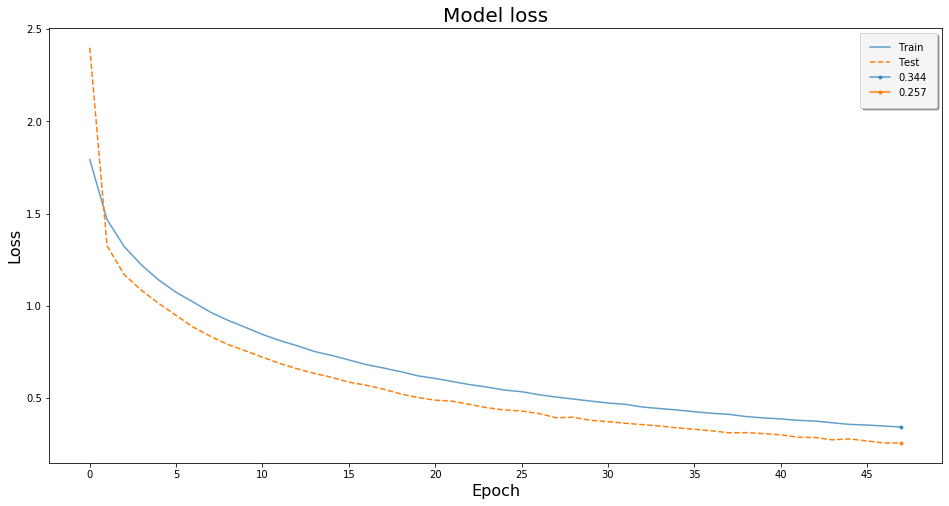

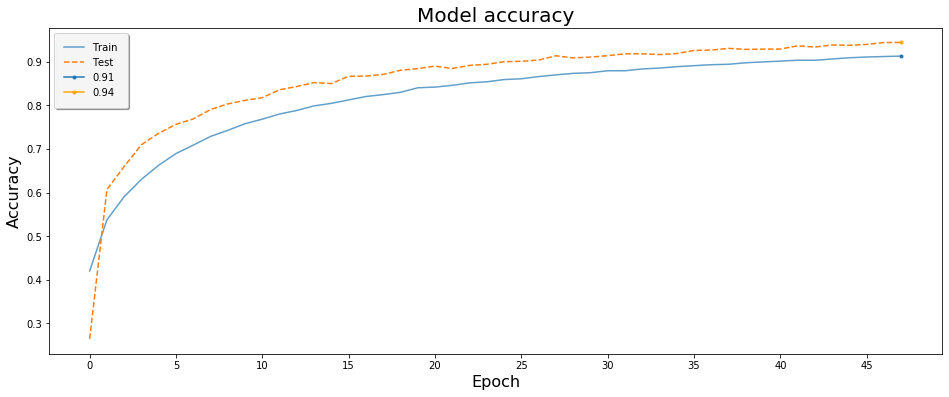

In [36]:
helpers.plot_train_history(history)

Training dynamics have changed in comparison to the last two experiments where the validation error reached a maximum value during the first few epochs before starting to minimize and becoming comparable with train loss. In this case the validation loss minimized since the first epoch, as we have more data representing what we want to predict. Generalization gap is noticeable by two smooth loss lines and the error difference looks quite the same than last experiment with Log-Mel Spectrograms.<br/>
<br/>

### 3. Model evaluation

#### * Register model output

In [54]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

/home/edu/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#### 3.1 Confusion matrix

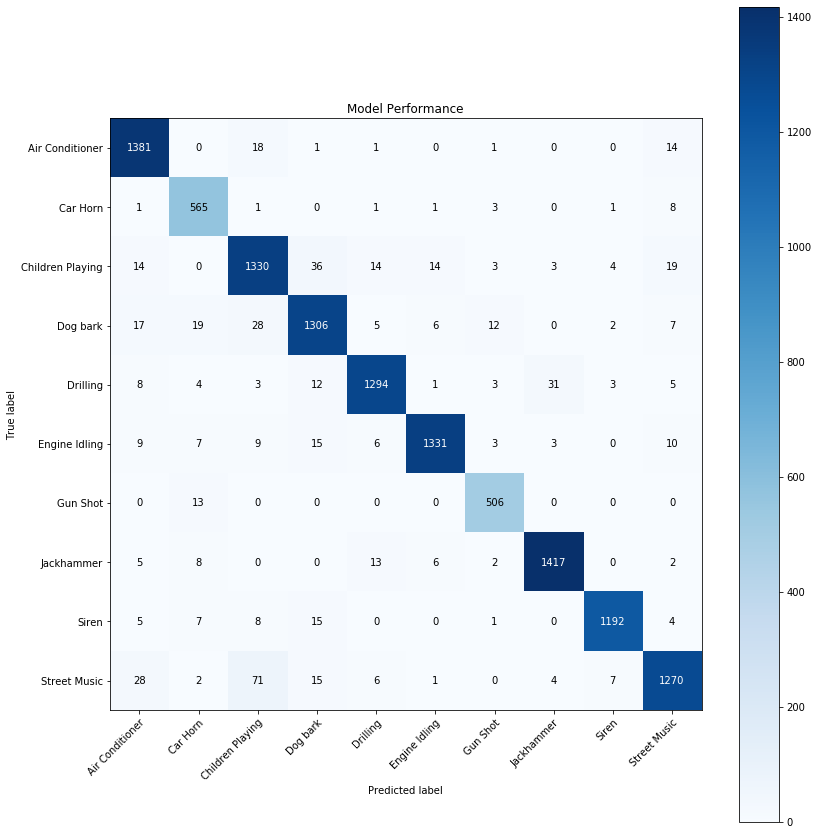

In [55]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

We now have multiple times more data than before in our test set but still we can see how some particular patterns are still present, hopefully, with a slighter effect. Usual misclassification cases still happen between **Street Music** and **Children Playing**, **Drilling** and **Jack Hammer** or **Dog Bark** and **Children Playing**.

#### 3.2 Accuracy table

In [56]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
0,Air Conditioner,97.528249
7,Jackhammer,97.522368
6,Gun Shot,97.495183
1,Car Horn,97.246127
8,Siren,96.753247
5,Engine Idling,95.549174
4,Drilling,94.868035
3,Dog bark,93.152639
2,Children Playing,92.553932
9,Street Music,90.455840


Happily, every class accuracy has raised! What's more interesting is that results are more balanced between classes now.<br/>

In [57]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.94      0.98      0.96      1416
        Car Horn       0.90      0.97      0.94       581
Children Playing       0.91      0.93      0.92      1437
        Dog bark       0.93      0.93      0.93      1402
        Drilling       0.97      0.95      0.96      1364
   Engine Idling       0.98      0.96      0.97      1393
        Gun Shot       0.95      0.97      0.96       519
      Jackhammer       0.97      0.98      0.97      1453
           Siren       0.99      0.97      0.98      1232
    Street Music       0.95      0.90      0.93      1404

        accuracy                           0.95     12201
       macro avg       0.95      0.95      0.95     12201
    weighted avg       0.95      0.95      0.95     12201



Similar to class accuracies, we see an increase in the average F1, Precision and Recall scores, and also, more balanced results. The common patterns we have been seeing for the last two experiments are still present but with a much slighter effect.<br/>
<br/>

## 4. Conclusion

All along this experiments we have learned how a very simple convolutional neural network can learn to recognize audible events, even when working with quite unbalanced datasets as the UrbanSound8K is. I would still like to experiment with different feature combinations; not that this performance scores are useless, we sure can use this model as it is to learn simple events like orders ("start", "right", "update", "stop", ...) or numbers for example.<br/>
<br/>
The amount of data showed to be a very important factor, until data augmentation training results where much more bound to the distribution of train/test splits: where it was easy to end up with a test split that wouldn't represent the train split. This didn't happen with augmented data.<br/>
<br/>
